### PYSPARK

In [1]:
%env PYSPARK_PYTHON=/Users/justin/miniconda3/envs/MassiveData/bin/python3
%env PYSPARK_DRIVER_PYTHON=~/miniconda3/envs/MassiveData/bin/ipython
%env JAVA_OPTS="-Xmx2g"

env: PYSPARK_PYTHON=/Users/justin/miniconda3/envs/MassiveData/bin/python3
env: PYSPARK_DRIVER_PYTHON=~/miniconda3/envs/MassiveData/bin/ipython
env: JAVA_OPTS="-Xmx2g"


In [2]:
from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession
import warnings
warnings.filterwarnings('ignore')
conf = SparkConf().setAppName("Project2")
spark = SparkSession.builder\
    .config(conf=conf)\
    .config("spark.driver.memory", "32g")\
    .getOrCreate()
# spark.sparkContext.setLogLevel("ERROR")
sc = spark.sparkContext
sc.setLogLevel("ERROR")

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/12/14 20:28:11 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
from functools import reduce

files = [f"flight_data/{_}.csv" for _ in range(2009, 2019)]

datasets_df = [spark.read.csv(_, header=True, inferSchema=True) for _ in files]

### Dataset Preview

In [5]:
datasets_df[0].printSchema()

root
 |-- FL_DATE: date (nullable = true)
 |-- OP_CARRIER: string (nullable = true)
 |-- OP_CARRIER_FL_NUM: integer (nullable = true)
 |-- ORIGIN: string (nullable = true)
 |-- DEST: string (nullable = true)
 |-- CRS_DEP_TIME: integer (nullable = true)
 |-- DEP_TIME: double (nullable = true)
 |-- DEP_DELAY: double (nullable = true)
 |-- TAXI_OUT: double (nullable = true)
 |-- WHEELS_OFF: double (nullable = true)
 |-- WHEELS_ON: double (nullable = true)
 |-- TAXI_IN: double (nullable = true)
 |-- CRS_ARR_TIME: integer (nullable = true)
 |-- ARR_TIME: double (nullable = true)
 |-- ARR_DELAY: double (nullable = true)
 |-- CANCELLED: double (nullable = true)
 |-- CANCELLATION_CODE: string (nullable = true)
 |-- DIVERTED: double (nullable = true)
 |-- CRS_ELAPSED_TIME: double (nullable = true)
 |-- ACTUAL_ELAPSED_TIME: double (nullable = true)
 |-- AIR_TIME: double (nullable = true)
 |-- DISTANCE: double (nullable = true)
 |-- CARRIER_DELAY: double (nullable = true)
 |-- WEATHER_DELAY: doub

### Preprocessing

In [4]:
processed_df = []
for i in range(len(datasets_df)):
    processed_df.append(datasets_df[i].drop("OP_CARRIER_FL_NUM").drop("OP_CARRIER").drop("DEP_DELAY").drop("CRS_DEP_TIME").drop("TAXI_OUT").drop("TAXI_IN").drop("WHEELS_OFF").drop("WHEELS_ON").drop("CRS_ARR_TIME").drop("CRS_ELAPSED_TIME").drop("Unnamed: 27").filter(datasets_df[i]["CANCELLED"] != 1.0).drop("CANCELLED").drop("CANCELLATION_CODE").drop("DIVERTED").drop("CARRIER_DELAY").drop("NAS_DELAY").drop("SECURITY_DELAY").drop("LATE_AIRCRAFT_DELAY").filter((datasets_df[i]["WEATHER_DELAY"].isNotNull()) & (datasets_df[i]["WEATHER_DELAY"] != 0.0)).drop("ARR_TIME").drop("ARR_DELAY").drop("ACTUAL_ELAPSED_TIME").drop("AIR_TIME"))

In [5]:
union_df = reduce(lambda df1, df2: df1.union(df2), processed_df)

In [8]:
union_df.select("WEATHER_DELAY").count()

637471

In [9]:
# union_df.groupby("ORIGIN").agg({"*": "count"}).sort("count(1)", ascending=False).show(50)

In [10]:
union_df.printSchema()

root
 |-- FL_DATE: date (nullable = true)
 |-- ORIGIN: string (nullable = true)
 |-- DEST: string (nullable = true)
 |-- DEP_TIME: double (nullable = true)
 |-- DISTANCE: double (nullable = true)
 |-- WEATHER_DELAY: double (nullable = true)



### One-hot Encoding

In [6]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, OneHotEncoder

# Step 1 & 2: Create a new DataFrame of unique origin and destination values
unique_orig_dest = union_df.select("ORIGIN").union(union_df.select("DEST")).distinct()
unique_orig_dest = unique_orig_dest.withColumnRenamed("ORIGIN", "location")

# Step 3: Fit the StringIndexer on the combined unique values
indexer = StringIndexer(inputCol="location", outputCol="location_index")
indexer_model = indexer.fit(unique_orig_dest)

# Step 4: Transform 'ORIGIN' and 'DEST' using the same model
union_df = indexer_model.transform(union_df.withColumnRenamed("ORIGIN", "location")).withColumnRenamed("location", "ORIGIN").withColumnRenamed("location_index", "ORIGIN_INDEX")
union_df = indexer_model.transform(union_df.withColumnRenamed("DEST", "location")).withColumnRenamed("location", "DEST").withColumnRenamed("location_index", "DEST_INDEX")

# Step 5: Apply OneHotEncoder separately
origin_onehot = OneHotEncoder(inputCol="ORIGIN_INDEX", outputCol="ORIGIN_ONEHOT")
dest_onehot = OneHotEncoder(inputCol="DEST_INDEX", outputCol="DEST_ONEHOT")

# Define the pipeline
pipeline = Pipeline(stages=[origin_onehot, dest_onehot])

# Fit and Transform
encoded_df = pipeline.fit(union_df).transform(union_df)

In [12]:
encoded_df.printSchema()

root
 |-- FL_DATE: date (nullable = true)
 |-- ORIGIN: string (nullable = true)
 |-- DEST: string (nullable = true)
 |-- DEP_TIME: double (nullable = true)
 |-- DISTANCE: double (nullable = true)
 |-- WEATHER_DELAY: double (nullable = true)
 |-- ORIGIN_INDEX: double (nullable = false)
 |-- DEST_INDEX: double (nullable = false)
 |-- ORIGIN_ONEHOT: vector (nullable = true)
 |-- DEST_ONEHOT: vector (nullable = true)



In [7]:
from pyspark.sql.functions import when

encoded_df = encoded_df.withColumn("WEATHER_DELAY_CLASS",
                   when(encoded_df["WEATHER_DELAY"] < 0, 0)
                   .when((encoded_df["WEATHER_DELAY"] >= 0) & (encoded_df["WEATHER_DELAY"] < 15), 1)
                   .when((encoded_df["WEATHER_DELAY"] >= 15) & (encoded_df["WEATHER_DELAY"] < 30), 2)
                   .when((encoded_df["WEATHER_DELAY"] >= 30) & (encoded_df["WEATHER_DELAY"] < 60), 3)
                   .when((encoded_df["WEATHER_DELAY"] >= 60) & (encoded_df["WEATHER_DELAY"] < 120), 4)
                   .otherwise(5))

In [8]:
origins = ["ORD", "DFW", "ATL", "DEN", "IAH", "MCO", "JFK", "MIA", "CLT", "EWR"]
dfs = dict()
for origin in origins:
    sub_df = encoded_df.filter(encoded_df['ORIGIN'] == origin)

    pandas_df = sub_df.toPandas()

    # Save the DataFrame to a CSV file
    file_name = f"Sliced_data/{origin}.csv"
    pandas_df.to_csv(file_name, index=False)

    # Store the DataFrame in the dictionary
    dfs[origin] = sub_df

### Weather Data

In [9]:
from functools import reduce

file = "Weather.csv"

weather_df = spark.read.option("header", "true").option("delimiter", ",").csv(file, inferSchema=True)

In [ ]:
weather_df.printSchema()

In [10]:
filtered_weather_df = weather_df["DATE", "STATION", "AWND", "FMTM", "PGTM", "PRCP", "TMIN", "TMAX", "WDF2", "WDF5", "WESD", "WSF2", "WSF5"]

In [ ]:
filtered_weather_df.select("STATION").distinct().collect()

In [11]:
origins = {"USW00094846": "ORD",
           "USW00003927": "DFW",
           "USW00013874": "ATL",
           "USW00003017": "DEN",
           "USW00012960": "IAH",
           "USW00012815": "MCO",
           "USW00094789": "JFK",
           "USW00012839": "MIA",
           "USW00013881": "CLT",
           "USW00014734": "EWR"}

weather_dfs = {}

for origin, name in origins.items():

    sub_weather_df = filtered_weather_df.filter(filtered_weather_df['STATION'] == origin)

    # Convert the Spark DataFrame to a Pandas DataFrame
    pandas_df = sub_weather_df.toPandas()

    # Save the DataFrame to a CSV file
    file_name = f"Weather_sliced_data/{name}.csv"
    pandas_df.to_csv(file_name, index=False)

    weather_dfs[name] = sub_weather_df

### ATL

In [12]:
from pyspark.sql.functions import col, to_date
from pyspark.sql.types import IntegerType, StringType, FloatType

In [13]:
ATL_flight = dfs["ATL"]
ATL_weather_data = weather_dfs["ATL"]

In [137]:
ATL_flight

DataFrame[FL_DATE: date, ORIGIN: string, DEST: string, DEP_TIME: double, DISTANCE: double, WEATHER_DELAY: double, ORIGIN_INDEX: double, DEST_INDEX: double, ORIGIN_ONEHOT: vector, DEST_ONEHOT: vector, WEATHER_DELAY_CLASS: int]

In [14]:
ATL_joined = ATL_flight.join(ATL_weather_data, ATL_flight.FL_DATE == ATL_weather_data.DATE, "inner")

In [15]:
ATL_joined = ATL_joined.drop("FL_DATE", "STATION")

In [144]:
ATL_joined.printSchema()

root
 |-- ORIGIN: string (nullable = true)
 |-- DEST: string (nullable = true)
 |-- DEP_TIME: double (nullable = true)
 |-- DISTANCE: double (nullable = true)
 |-- WEATHER_DELAY: double (nullable = true)
 |-- ORIGIN_INDEX: double (nullable = false)
 |-- DEST_INDEX: double (nullable = false)
 |-- ORIGIN_ONEHOT: vector (nullable = true)
 |-- DEST_ONEHOT: vector (nullable = true)
 |-- WEATHER_DELAY_CLASS: integer (nullable = false)
 |-- DATE: date (nullable = true)
 |-- AWND: double (nullable = true)
 |-- FMTM: double (nullable = true)
 |-- PGTM: double (nullable = true)
 |-- PRCP: double (nullable = true)
 |-- TMIN: integer (nullable = true)
 |-- TMAX: integer (nullable = true)
 |-- WDF2: double (nullable = true)
 |-- WDF5: double (nullable = true)
 |-- WESD: double (nullable = true)
 |-- WSF2: double (nullable = true)
 |-- WSF5: double (nullable = true)



In [74]:
import matplotlib.pyplot as plt

In [16]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd
import torch.optim as optim
from sklearn.metrics import accuracy_score

ATL_pandas = ATL_joined.toPandas()

# Selecting relevant features and the label
features = ['DEP_TIME', 'DISTANCE', 'ORIGIN_INDEX', 'DEST_INDEX', 'AWND', 'FMTM', 'PGTM', 'PRCP', 'TMIN', 'TMAX', 'WDF2', 'WDF5', 'WESD', 'WSF2', 'WSF5']
label = 'WEATHER_DELAY_CLASS'

# Normalizing/Standardizing the features
scaler = StandardScaler()
ATL_pandas[features] = scaler.fit_transform(ATL_pandas[features])

# Converting to PyTorch tensors
X = torch.tensor(ATL_pandas[features].values, dtype=torch.float32)
X = torch.nan_to_num(X)
y = torch.tensor(ATL_pandas[label].values, dtype=torch.long)

# Splitting the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [45]:
X_train[0].shape

torch.Size([15])

In [17]:
device = torch.device("mps")

#### RNN

In [18]:
hidden_size = 128
num_classes = 6
num_epochs = 100
batch_size = 64
learning_rate = 0.001
input_size = 15
sequence_length = 1
num_layers = 2

In [19]:
train_data = TensorDataset(X_train, y_train)
test_data = TensorDataset(X_test, y_test)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

In [20]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(RNN, self).__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        out, _ = self.rnn(x, h0)
        out = out[:, -1, :]
        out = self.fc(out)
        return out

In [21]:
ATL_RNN_model = RNN(input_size, hidden_size, num_layers, num_classes).to(device)
RNN_criterion = nn.CrossEntropyLoss()
RNN_optimizer = torch.optim.Adam(ATL_RNN_model.parameters(), lr=learning_rate)

In [22]:
n_total_steps = len(train_loader)
RNN_loss = []
RNN_acc = []
for epoch in range(num_epochs):
    for i, (inputs, labels) in enumerate(train_loader):
        inputs = inputs.reshape(-1, sequence_length, input_size).to(device)
        labels = labels.to(device)

        outputs = ATL_RNN_model(inputs)
        loss = RNN_criterion(outputs, labels)

        RNN_optimizer.zero_grad()
        loss.backward()
        RNN_optimizer.step()

        if (i + 1) % 100 == 0:
            print(f"Epoch [{epoch + 1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}")

        RNN_loss.append(loss.item())

    with torch.no_grad():
        n_correct = 0
        n_sample = 0
        for inputs, labels in test_loader:
            inputs = inputs.reshape(-1, sequence_length, input_size).to(device)
            labels = labels.to(device)
            outputs = ATL_RNN_model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            n_sample += labels.size(0)
            n_correct += (predicted == labels).sum().item()

        acc = 100.0 * n_correct / n_sample
        print(f"Accuracy: {acc:.4f}%")
        RNN_acc.append(acc)

Epoch [1/100], Step [100/677], Loss: 1.6100
Epoch [1/100], Step [200/677], Loss: 1.4902
Epoch [1/100], Step [300/677], Loss: 1.3582
Epoch [1/100], Step [400/677], Loss: 1.4521
Epoch [1/100], Step [500/677], Loss: 1.4740
Epoch [1/100], Step [600/677], Loss: 1.4595
Accuracy: 37.3476%
Epoch [2/100], Step [100/677], Loss: 1.4838
Epoch [2/100], Step [200/677], Loss: 1.3782
Epoch [2/100], Step [300/677], Loss: 1.5150
Epoch [2/100], Step [400/677], Loss: 1.3872
Epoch [2/100], Step [500/677], Loss: 1.5397
Epoch [2/100], Step [600/677], Loss: 1.4030
Accuracy: 37.2830%
Epoch [3/100], Step [100/677], Loss: 1.3636
Epoch [3/100], Step [200/677], Loss: 1.4641
Epoch [3/100], Step [300/677], Loss: 1.4802
Epoch [3/100], Step [400/677], Loss: 1.4154
Epoch [3/100], Step [500/677], Loss: 1.4480
Epoch [3/100], Step [600/677], Loss: 1.3660
Accuracy: 37.0521%
Epoch [4/100], Step [100/677], Loss: 1.3282
Epoch [4/100], Step [200/677], Loss: 1.5652
Epoch [4/100], Step [300/677], Loss: 1.3715
Epoch [4/100], Step

In [23]:
torch.save(ATL_RNN_model.state_dict(), "RNN_Model.pt")

Text(0.5, 1.0, 'RNN Loss')

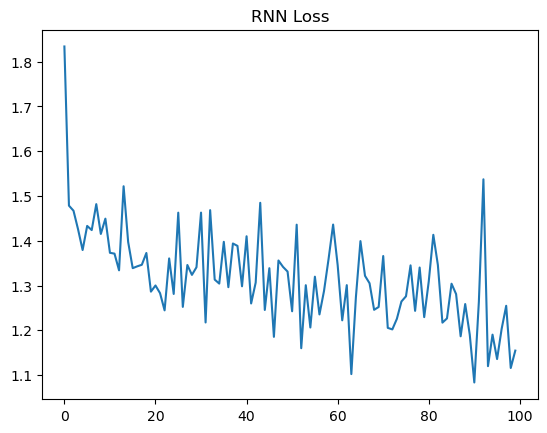

In [78]:
plt.plot(range(100), RNN_loss[::677])
plt.title("RNN Loss")

Text(0.5, 1.0, 'RNN Accuracy')

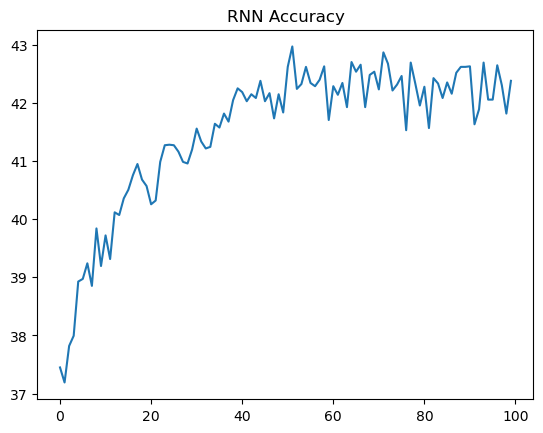

In [79]:
plt.plot(range(100), RNN_acc)
plt.title("RNN Accuracy")

#### GRU

In [24]:
class RNN_GRU(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(RNN_GRU, self).__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.rnn = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        out, _ = self.rnn(x, h0)
        out = out[:, -1, :]
        out = self.fc(out)
        return out

In [25]:
ATL_GRU_model = RNN_GRU(input_size, hidden_size, num_layers, num_classes).to(device)
RNN_GRU_criterion = nn.CrossEntropyLoss()
RNN_GRU_optimizer = torch.optim.Adam(ATL_GRU_model.parameters(), lr=learning_rate)

In [26]:
n_total_steps = len(train_loader)
RNN_GRU_loss = []
RNN_GRU_acc = []
for epoch in range(num_epochs):
    for i, (inputs, labels) in enumerate(train_loader):
        inputs = inputs.reshape(-1, sequence_length, input_size).to(device)
        labels = labels.to(device)

        outputs = ATL_GRU_model(inputs)
        loss = RNN_GRU_criterion(outputs, labels)

        RNN_GRU_optimizer.zero_grad()
        loss.backward()
        RNN_GRU_optimizer.step()

        if (i + 1) % 100 == 0:
            print(f"Epoch [{epoch + 1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}")

        RNN_GRU_loss.append(loss.item())

    with torch.no_grad():
        n_correct = 0
        n_sample = 0
        for inputs, labels in test_loader:
            inputs = inputs.reshape(-1, sequence_length, input_size).to(device)
            labels = labels.to(device)
            outputs = ATL_GRU_model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            n_sample += labels.size(0)
            n_correct += (predicted == labels).sum().item()

        acc = 100.0 * n_correct / n_sample
        print(f"Accuracy: {acc:.4f}%")
        RNN_GRU_acc.append(acc)

Epoch [1/100], Step [100/677], Loss: 1.4939
Epoch [1/100], Step [200/677], Loss: 1.5213
Epoch [1/100], Step [300/677], Loss: 1.4206
Epoch [1/100], Step [400/677], Loss: 1.5350
Epoch [1/100], Step [500/677], Loss: 1.6121
Epoch [1/100], Step [600/677], Loss: 1.4991
Accuracy: 33.8936%
Epoch [2/100], Step [100/677], Loss: 1.4881
Epoch [2/100], Step [200/677], Loss: 1.4434
Epoch [2/100], Step [300/677], Loss: 1.5612
Epoch [2/100], Step [400/677], Loss: 1.5408
Epoch [2/100], Step [500/677], Loss: 1.5558
Epoch [2/100], Step [600/677], Loss: 2.8947
Accuracy: 36.1008%
Epoch [3/100], Step [100/677], Loss: 1.5674
Epoch [3/100], Step [200/677], Loss: 1.8961
Epoch [3/100], Step [300/677], Loss: 1.3877
Epoch [3/100], Step [400/677], Loss: 1.6433
Epoch [3/100], Step [500/677], Loss: 1.4676
Epoch [3/100], Step [600/677], Loss: 1.5944
Accuracy: 26.1729%
Epoch [4/100], Step [100/677], Loss: 1.5926
Epoch [4/100], Step [200/677], Loss: 1.6398
Epoch [4/100], Step [300/677], Loss: 1.4786
Epoch [4/100], Step

In [27]:
torch.save(ATL_GRU_model.state_dict(), "GRU_Model.pt")

Text(0.5, 1.0, 'GRU Loss')

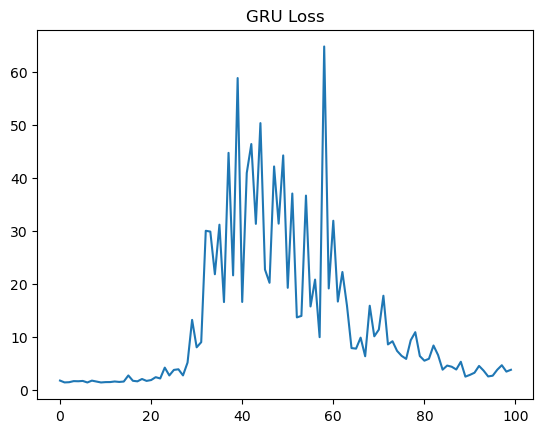

In [84]:
plt.plot(range(100), RNN_GRU_loss[::677])
plt.title("GRU Loss")

Text(0.5, 1.0, 'GRU Accuracy')

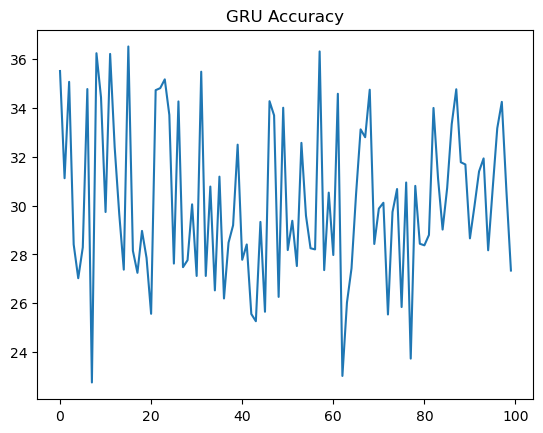

In [91]:
plt.plot(range(100), RNN_GRU_acc)
plt.title("GRU Accuracy")

#### LSTM

In [28]:
class RNN_LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(RNN_LSTM, self).__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.rnn = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        out, _ = self.rnn(x, (h0, c0))
        out = out[:, -1, :]
        out = self.fc(out)
        return out

In [29]:
ATL_LSTM_model = RNN_LSTM(input_size, hidden_size, num_layers, num_classes).to(device)
RNN_LSTM_criterion = nn.CrossEntropyLoss()
RNN_LSTM_optimizer = torch.optim.Adam(ATL_LSTM_model.parameters(), lr=learning_rate)

In [30]:
n_total_steps = len(train_loader)
RNN_LSTM_loss = []
RNN_LSTM_acc = []
for epoch in range(num_epochs):
    for i, (inputs, labels) in enumerate(train_loader):
        inputs = inputs.reshape(-1, sequence_length, input_size).to(device)
        labels = labels.to(device)

        outputs = ATL_LSTM_model(inputs)
        loss = RNN_LSTM_criterion(outputs, labels)

        RNN_LSTM_optimizer.zero_grad()
        loss.backward()
        RNN_LSTM_optimizer.step()

        if (i + 1) % 100 == 0:
            print(f"Epoch [{epoch + 1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}")

        RNN_LSTM_loss.append(loss.item())

    with torch.no_grad():
        n_correct = 0
        n_sample = 0
        for inputs, labels in test_loader:
            inputs = inputs.reshape(-1, sequence_length, input_size).to(device)
            labels = labels.to(device)
            outputs = ATL_LSTM_model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            n_sample += labels.size(0)
            n_correct += (predicted == labels).sum().item()

        acc = 100.0 * n_correct / n_sample
        print(f"Accuracy: {acc:.4f}%")
        RNN_LSTM_acc.append(acc)

Epoch [1/100], Step [100/677], Loss: 1.4593
Epoch [1/100], Step [200/677], Loss: 1.5218
Epoch [1/100], Step [300/677], Loss: 1.5180
Epoch [1/100], Step [400/677], Loss: 1.3658
Epoch [1/100], Step [500/677], Loss: 1.4027
Epoch [1/100], Step [600/677], Loss: 1.5336
Accuracy: 37.5231%
Epoch [2/100], Step [100/677], Loss: 1.2597
Epoch [2/100], Step [200/677], Loss: 1.5370
Epoch [2/100], Step [300/677], Loss: 1.4769
Epoch [2/100], Step [400/677], Loss: 1.4259
Epoch [2/100], Step [500/677], Loss: 1.3609
Epoch [2/100], Step [600/677], Loss: 1.3878
Accuracy: 37.9756%
Epoch [3/100], Step [100/677], Loss: 1.3065
Epoch [3/100], Step [200/677], Loss: 1.3637
Epoch [3/100], Step [300/677], Loss: 1.4485
Epoch [3/100], Step [400/677], Loss: 1.5803
Epoch [3/100], Step [500/677], Loss: 1.3555
Epoch [3/100], Step [600/677], Loss: 1.4474
Accuracy: 38.0680%
Epoch [4/100], Step [100/677], Loss: 1.3336
Epoch [4/100], Step [200/677], Loss: 1.3871
Epoch [4/100], Step [300/677], Loss: 1.3596
Epoch [4/100], Step

In [31]:
torch.save(ATL_LSTM_model.state_dict(), "LSTM_Model.pt")

Text(0.5, 1.0, 'LSTM Loss')

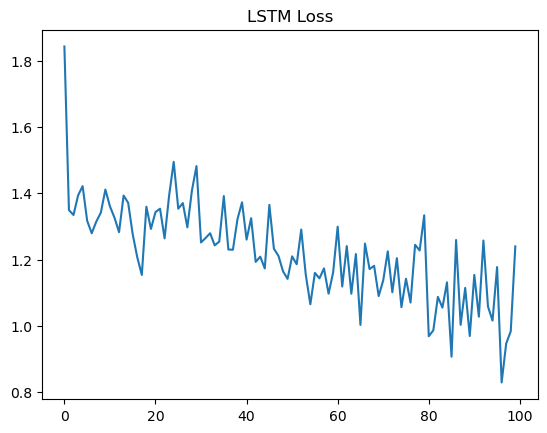

In [89]:
plt.plot(range(100), RNN_LSTM_loss[::677])
plt.title("LSTM Loss")

Text(0.5, 1.0, 'LSTM Accuracy')

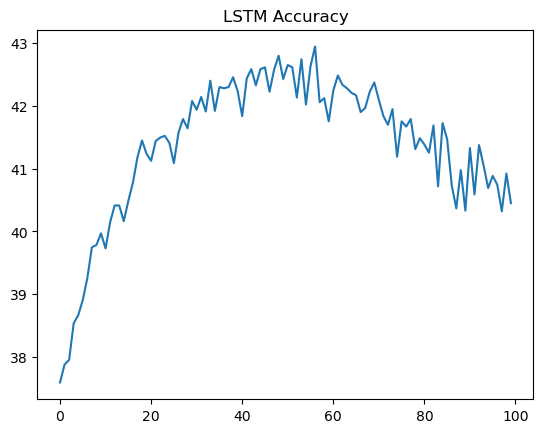

In [90]:
plt.plot(range(100), RNN_LSTM_acc)
plt.title("LSTM Accuracy")

#### MLP

In [32]:
class MLPModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(MLPModel, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size * 4)
        self.dropout = nn.Dropout(0.5)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size * 4, hidden_size * 4)
        self.fc3 = nn.Linear(hidden_size * 4, hidden_size)
        self.fc4 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.dropout(out)
        out = self.relu(out)
        out = self.fc3(out)
        out = self.dropout(out)
        out = self.fc4(out)
        return out

In [33]:
input_size = 15  # As you have 15 features
hidden_size = 128  # This is adjustable based on your dataset
num_classes = 6  # You mentioned having 6 classes

# Initialize the model, loss function, and optimizer
ATL_MLP_model = MLPModel(input_size, hidden_size, num_classes).to(device)

MLP_criterion = nn.CrossEntropyLoss()
MLP_optimizer = optim.Adam(ATL_MLP_model.parameters(), lr=0.001)

In [34]:
n_total_steps = len(train_loader)
MLP_loss = []
MLP_acc = []

for epoch in range(num_epochs):
    ATL_MLP_model.train()
    for i, (inputs, labels) in enumerate(train_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = ATL_MLP_model(inputs)

        loss = MLP_criterion(outputs, labels)

        MLP_optimizer.zero_grad()
        loss.backward()
        MLP_optimizer.step()

        if (i + 1) % 100 == 0:
            print(f"Epoch [{epoch + 1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}")

        MLP_loss.append(loss.item())

    with torch.no_grad():
        n_correct = 0
        n_sample = 0
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = ATL_MLP_model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            n_sample += labels.size(0)
            n_correct += (predicted == labels).sum().item()

        acc = 100.0 * n_correct / n_sample
        print(f"Accuracy: {acc:.4f}%")
        MLP_acc.append(acc)

Epoch [1/100], Step [100/677], Loss: 1.5170
Epoch [1/100], Step [200/677], Loss: 1.6082
Epoch [1/100], Step [300/677], Loss: 1.4770
Epoch [1/100], Step [400/677], Loss: 1.5156
Epoch [1/100], Step [500/677], Loss: 1.4715
Epoch [1/100], Step [600/677], Loss: 1.4945
Accuracy: 37.8094%
Epoch [2/100], Step [100/677], Loss: 1.4816
Epoch [2/100], Step [200/677], Loss: 1.2920
Epoch [2/100], Step [300/677], Loss: 1.4988
Epoch [2/100], Step [400/677], Loss: 1.4908
Epoch [2/100], Step [500/677], Loss: 1.4066
Epoch [2/100], Step [600/677], Loss: 1.4011
Accuracy: 37.2553%
Epoch [3/100], Step [100/677], Loss: 1.3751
Epoch [3/100], Step [200/677], Loss: 1.4908
Epoch [3/100], Step [300/677], Loss: 1.4064
Epoch [3/100], Step [400/677], Loss: 1.3816
Epoch [3/100], Step [500/677], Loss: 1.4043
Epoch [3/100], Step [600/677], Loss: 1.5325
Accuracy: 37.7263%
Epoch [4/100], Step [100/677], Loss: 1.3746
Epoch [4/100], Step [200/677], Loss: 1.4429
Epoch [4/100], Step [300/677], Loss: 1.3372
Epoch [4/100], Step

In [35]:
torch.save(ATL_MLP_model.state_dict(), "MLP_Model.pt")

In [128]:
epochs = range(100)

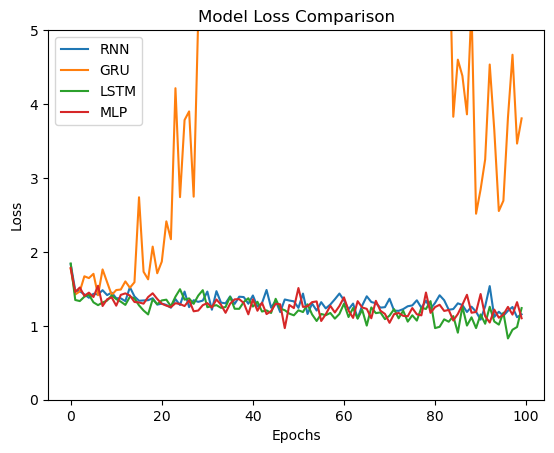

In [142]:
plt.plot(epochs, RNN_loss[::677], label="RNN")
plt.plot(epochs, RNN_GRU_loss[::677], label="GRU")
plt.plot(epochs, RNN_LSTM_loss[::677], label="LSTM")
plt.plot(epochs, MLP_loss[::677], label="MLP")
plt.title("Model Loss Comparison")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.ylim(0, 5)
plt.legend()
plt.show()

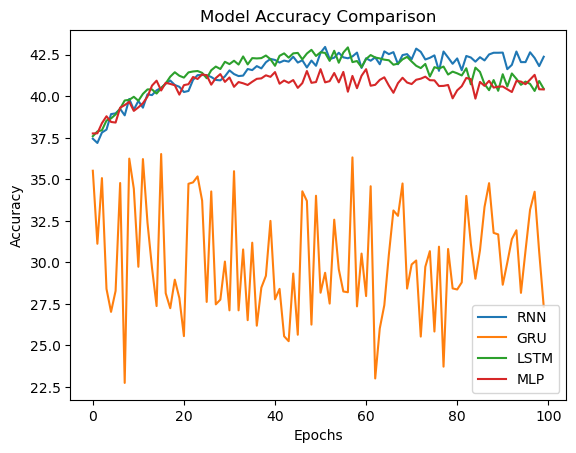

In [143]:
plt.plot(epochs, RNN_acc, label="RNN")
plt.plot(epochs, RNN_GRU_acc, label="GRU")
plt.plot(epochs, RNN_LSTM_acc, label="LSTM")
plt.plot(epochs, MLP_acc, label="MLP")
plt.title("Model Accuracy Comparison")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [55]:
import numpy as np

### Test

In [67]:
for i, (inputs, labels) in enumerate(test_loader):
    print("RNN: ", np.argmax(ATL_RNN_model(inputs.reshape(-1, sequence_length, input_size).to(device)).cpu().detach()[0]).item(), end=" ")
    print("GRU: ", np.argmax(ATL_GRU_model(inputs.reshape(-1, sequence_length, input_size).to(device)).cpu().detach()[0]).item(), end=" ")
    print("LSTM: ", np.argmax(ATL_LSTM_model(inputs.reshape(-1, sequence_length, input_size).to(device)).cpu().detach()[0]).item(), end=" ")
    print("MLP: ", np.argmax(ATL_MLP_model(inputs.to(device)).cpu().detach()[0]).item(), end=" ")
    print("Label: ", labels[0].item())
    if i > 100:
        break

RNN:  3 GRU:  1 LSTM:  3 MLP:  2 Label:  1
RNN:  1 GRU:  1 LSTM:  2 MLP:  1 Label:  1
RNN:  1 GRU:  1 LSTM:  1 MLP:  1 Label:  4
RNN:  1 GRU:  1 LSTM:  2 MLP:  1 Label:  2
RNN:  1 GRU:  1 LSTM:  1 MLP:  1 Label:  1
RNN:  1 GRU:  1 LSTM:  1 MLP:  1 Label:  1
RNN:  1 GRU:  1 LSTM:  1 MLP:  1 Label:  2
RNN:  2 GRU:  1 LSTM:  2 MLP:  4 Label:  3
RNN:  4 GRU:  1 LSTM:  1 MLP:  5 Label:  5
RNN:  2 GRU:  1 LSTM:  5 MLP:  1 Label:  4
RNN:  5 GRU:  1 LSTM:  2 MLP:  5 Label:  2
RNN:  4 GRU:  1 LSTM:  4 MLP:  4 Label:  2
RNN:  1 GRU:  1 LSTM:  1 MLP:  1 Label:  1
RNN:  5 GRU:  1 LSTM:  2 MLP:  2 Label:  2
RNN:  2 GRU:  1 LSTM:  2 MLP:  3 Label:  1
RNN:  2 GRU:  1 LSTM:  1 MLP:  1 Label:  2
RNN:  1 GRU:  1 LSTM:  1 MLP:  1 Label:  1
RNN:  1 GRU:  1 LSTM:  1 MLP:  1 Label:  1
RNN:  5 GRU:  1 LSTM:  5 MLP:  5 Label:  4
RNN:  2 GRU:  1 LSTM:  1 MLP:  2 Label:  1
RNN:  1 GRU:  1 LSTM:  1 MLP:  1 Label:  1
RNN:  5 GRU:  1 LSTM:  1 MLP:  1 Label:  3
RNN:  3 GRU:  1 LSTM:  2 MLP:  1 Label:  2
RNN:  1 GRU